In [1]:
import torch
import time
import librosa
import pathlib
import numpy as np
import numpy as np
import pandas as pd
import sounddevice as sd
import matplotlib.pyplot as plt

from torch import nn, optim
from dataclasses import dataclass
from tqdm import tqdm
from train_net import train
from scipy.io.wavfile import write
from torch.utils.data import TensorDataset, DataLoader

TRAIN = False

In [2]:
def preprocess_audio(filename, spec_params):

    audio, sample_rate = librosa.load(filename, sr=spec_params.sample_rate)
    audio, _ = librosa.effects.trim(audio)

    if len(audio) < 0.1 * sample_rate:
        return None

    if len(audio) < spec_params.target_length:
        audio = np.pad(audio, (0, spec_params.target_length - len(audio)), "constant")
    else:
        audio = audio[: spec_params.target_length]

    S = librosa.feature.melspectrogram(
        y=audio,
        sr=sample_rate,
        n_mels=spec_params.n_mels,
        n_fft=spec_params.n_fft,
        win_length=spec_params.window_length,
        hop_length=round(spec_params.window_length / 2),
    )

    S_dB = 20 * np.log10(S + 1e-6)
    S_dB = (S_dB - np.max(S_dB)) / (np.max(S_dB) - np.min(S_dB))

    return S_dB

In [3]:
def create_dataset(audios_folder, data_labels, specgram_params):
    audio_files = pathlib.Path(audios_folder).rglob("*.wav")
    audios_df = pd.DataFrame({"filename": list(audio_files)})

    audios_df["label"] = audios_df.filename.apply(lambda x: str(x).split("/")[-2])
    audios_df["value"] = audios_df.label.map(data_labels)

    specgrams = []
    labels = []

    for _, audio in tqdm(audios_df.iterrows(), total=len(audios_df)):
        specgram = preprocess_audio(audio["filename"], specgram_params)

        if specgram is None:
            continue

        labels.append(audio["value"])
        specgrams.append(specgram[np.newaxis, :, :])

    X_tensor = torch.tensor(np.array(specgrams), dtype=torch.float32)
    Y_tensor = torch.tensor(np.array(labels), dtype=torch.long)

    dataset = TensorDataset(X_tensor, Y_tensor)

    return dataset

In [4]:
@dataclass
class SpectrogramParams:
    n_mels: int
    sample_rate: int
    frame_duration: float
    window_length: int
    n_fft: int
    target_length: int


target_duration = 1.1  # target duration in seconds
frame_duration = 0.03  # frame duration in seconds
sample_rate = 16000
window_length = round(frame_duration * sample_rate)

spec_params = SpectrogramParams(
    n_mels=32,
    sample_rate=16000,
    frame_duration=frame_duration,
    window_length=window_length,
    n_fft=2 ** (round(window_length) - 1).bit_length(),
    target_length=round(target_duration * sample_rate),
)

data_labels = {
    "cero": 0,
    "uno": 1,
    "dos": 2,
    "tres": 3,
    "cuatro": 4,
    "cinco": 5,
    "seis": 6,
    "siete": 7,
    "ocho": 8,
    "nueve": 9,
}

if TRAIN:
    training_dataset = create_dataset("data/train/", data_labels, spec_params)
    validation_dataset = create_dataset("data/test", data_labels, spec_params)

    torch.save(training_dataset, "training_dataset.pt")
    torch.save(validation_dataset, "validation_dataset.pt")

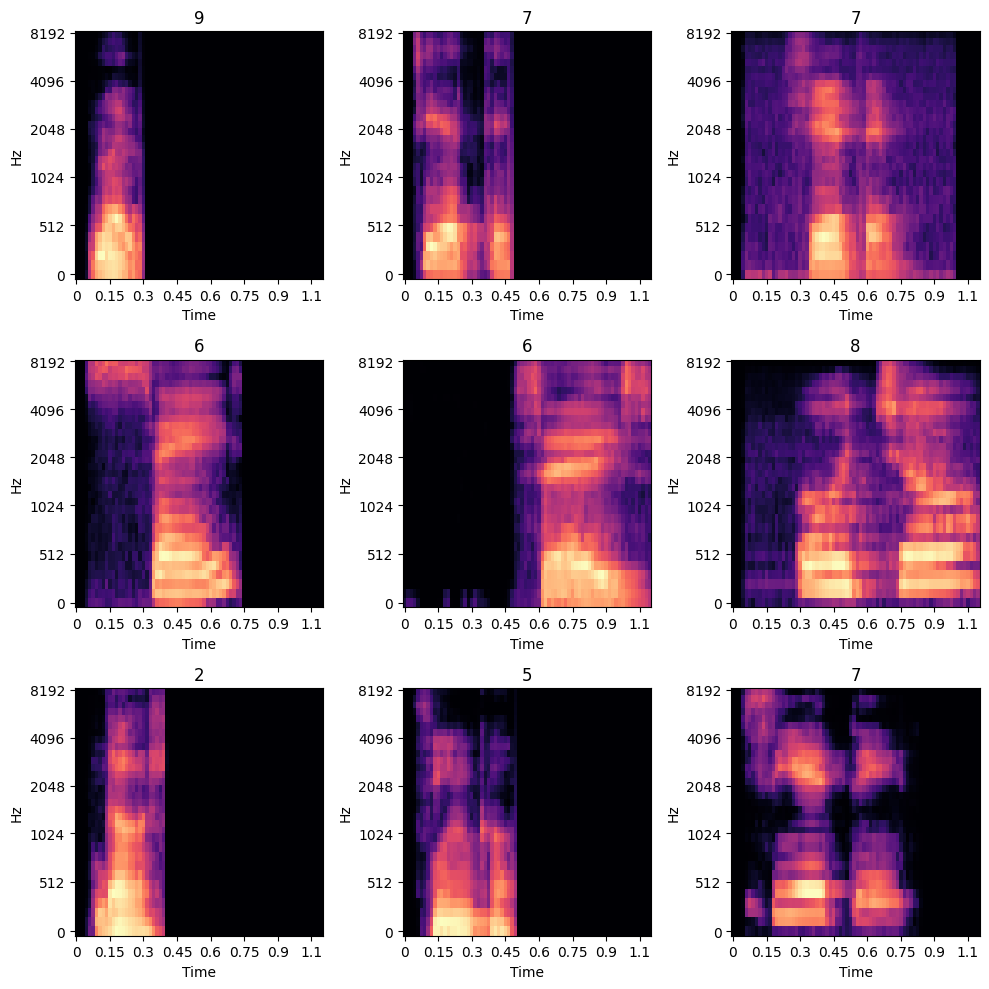

In [5]:
def show_samples(dataset, nrows=3, ncols=3):
    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))

    for i in range(nrows):
        for j in range(ncols):
            idx = np.random.randint(0, len(dataset))
            specgram, label = dataset[idx]

            librosa.display.specshow(
                specgram[0].numpy(),
                sr=spec_params.sample_rate,
                hop_length=round(spec_params.window_length / 2),
                x_axis="time",
                y_axis="mel",
                ax=axes[i, j],
            )
            axes[i, j].set_title(label.item())

    plt.tight_layout()


training_dataset = torch.load("training_dataset.pt")
show_samples(training_dataset)

In [6]:
class conv_layer(nn.Sequential):
    def __init__(self, input_feat, out_feat, max_pool=True):
        layers = []
        layers.append(nn.Conv2d(input_feat, out_feat, 3, padding=1))
        layers.append(nn.BatchNorm2d(out_feat))
        layers.append(nn.ReLU())

        if max_pool:
            layers.append(nn.MaxPool2d(3, 2, padding=1))
        super().__init__(*layers)


class Flatten(nn.Module):
    def forward(self, x):
        return torch.flatten(x, start_dim=1)


class MyNet(nn.Sequential):
    def __init__(self, dropoutProb=0.2, num_classes=10):
        input_channels = 1
        numF = 16

        layers = []
        layers.append(conv_layer(input_channels, numF))
        layers.append(conv_layer(numF, numF * 2))
        layers.append(conv_layer(2 * numF, 4 * numF))
        layers.append(conv_layer(4 * numF, 4 * numF, max_pool=False))
        layers.append(conv_layer(4 * numF, 4 * numF, max_pool=False))
        layers.append(nn.AdaptiveMaxPool2d((4, 1)))
        layers.append(nn.Dropout2d(dropoutProb))
        layers.append(Flatten())
        layers.append(nn.Linear(64 * 4, num_classes))

        super().__init__(*layers)

In [7]:
if TRAIN:
    device = "cpu"

    learning_rate = 0.001
    batch_size = 512

    red = MyNet()

    optimizer = optim.Adam(red.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()

    num_epochs = 30
    train_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(
        validation_dataset, batch_size=batch_size, shuffle=False
    )

    start_time = time.time()
    torch.set_num_threads(4)
    train_losses, val_losses, train_acc, val_acc = train(
        red,
        loss_fn,
        train_dataloader,
        val_dataloader,
        optimizer,
        num_epochs,
        device=device,
    )

    torch.save(red.state_dict(), "model.pth")
    print(f"Train finished in {time.time()- start_time} seconds")

    fig, axes = plt.subplots(2, 1)
    axes[0].plot(train_losses, label="train loss")
    axes[0].plot(val_losses, label="val_loss")
    axes[0].legend()
    axes[0].set_xlabel("epoch")
    axes[0].set_ylabel("Loss")

    axes[1].plot(train_acc, label="train_acc")
    axes[1].plot(val_acc, label="val acc")
    axes[1].legend()
    axes[1].set_xlabel("epoch")
    axes[1].set_ylabel("Accuracy")

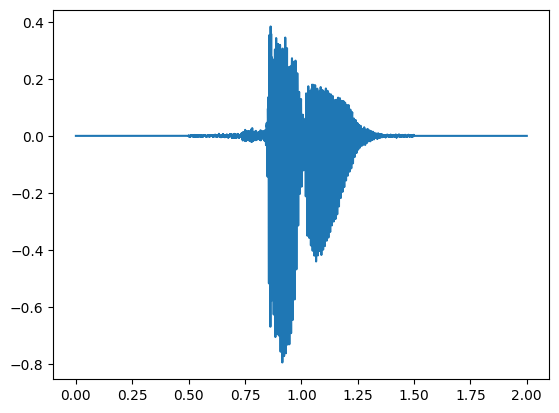

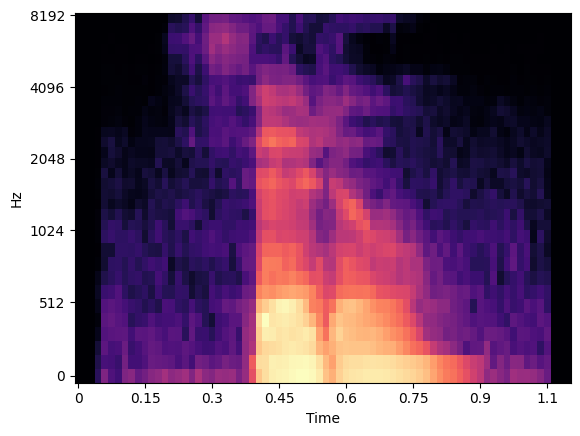

Has dicho:  0


In [13]:
duration = 3
freq = 16000

record = sd.rec(int(duration * freq), samplerate=freq, channels=1)
sd.wait()

write("file.wav", 16000, record)

audio_data, fs = librosa.load("file.wav")
t = np.arange(len(audio_data)) / fs
plt.plot(t, audio_data)
plt.show()

S = preprocess_audio("file.wav", spec_params)
librosa.display.specshow(S, sr=16000, hop_length=240, x_axis="time", y_axis="mel")
plt.show()

# load saved model
red = MyNet()
red.load_state_dict(torch.load("model.pth"))

red.eval()
x = torch.from_numpy(S.astype(np.float32))
x = x.unsqueeze(0).unsqueeze(0)  # añadimos dimensiones para poder hacer la inferencia
x = x.to("cpu")
y = red(x)

print("Has dicho: ", torch.argmax(y).item())  # clasificamos con el máximo